In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [73]:
PATH = 'SAC_6th Annual Datathon_Data/Spotify_Daily_Top_50.xlsx'
spotify = pd.DataFrame()
for i in range(1,27):
    temp = pd.read_excel(PATH, sheet_name=f'page_{i}')
    spotify = pd.concat([spotify, temp])
print(spotify.shape)
print(spotify['artists'].nunique())

(1667094, 25)
11279


### FILTER 1

In [74]:
spotify['country'] = spotify['country'].fillna('Global Top 50')
print(spotify.shape)
spotify = spotify[spotify['country'].isin(['US','Global Top 50','SV','ET','CN'])]
all_songs = spotify.copy()
print("After selecting region ",spotify.shape)
print(spotify['artists'].nunique())
spotify = spotify[spotify['popularity']>63]
print("After dropping low popular ",spotify.shape)

(1667094, 25)
After selecting region  (68437, 25)
685
After dropping low popular  (66895, 25)


In [4]:
columns_to_keep = ['spotify_id', 'snapshot_date', 'name', 'artists', 'daily_rank', 'weekly_movement', 'popularity',
       'duration_ms', 'album_name', 'danceability', 'energy', 'loudness', 'liveness', 'valence', 'tempo']
spotify = spotify[columns_to_keep]
print(spotify.shape)
spotify = spotify.drop_duplicates()
print("After dropping duplicates ",spotify.shape)

(66895, 15)
After dropping duplicates  (66596, 15)


In [5]:
spotify.head()

,spotify_id,snapshot_date,name,artists,daily_rank,weekly_movement,popularity,duration_ms,album_name,danceability,energy,loudness,liveness,valence,tempo
0,2plbrEY59IikOBgBGLjaoe,2025-01-31,Die With A Smile,"Lady Gaga, Bruno Mars",1,1,100,251667,Die With A Smile,0.521,0.59200,-7.777,0.1220,0.535,157.969
1,3sK8wGT43QFpWrvNQsrQya,2025-01-31,DtMF,Bad Bunny,2,-1,98,237117,DeBÍ TiRAR MáS FOToS,0.625,0.13100,-27.405,0.0807,0.032,136.020
2,4wJ5Qq0jBN4ajy7ouZIV1c,2025-01-31,APT.,"ROSÉ, Bruno Mars",3,0,91,169917,rosie,0.777,0.78300,-4.477,0.3550,0.939,149.027
3,2lTm559tuIvatlT1u0JYG2,2025-01-31,BAILE INoLVIDABLE,Bad Bunny,4,0,95,367725,DeBÍ TiRAR MáS FOToS,0.168,0.00332,-46.113,0.1120,0.219,119.387
4,5TFD2bmFKGhoCRbX61nXY5,2025-01-31,NUEVAYoL,Bad Bunny,5,1,94,183685,DeBÍ TiRAR MáS FOToS,0.142,0.19500,-20.024,0.2040,0.120,137.922


### FILTER 2

- If artist has popularity < 80, there is biasness in songs hit
- If artist can't make in top 50 for atleast 60 times, it got trendy because of some reason but audiences don't vibe on that after that
    - for new songs we will give exceptions and treat them differently

In [6]:
spotify.groupby(['name']).agg({'daily_rank':'count'}).reset_index().sort_values(by='daily_rank', ascending=False)

,name,daily_rank
465,Lose Control,729
430,LUNA,702
600,PERRO NEGRO,671
86,Beautiful Things,669
767,Stick Season,657
...,...,...
226,El Año Viejo,1
932,Winter Wonderland - Remastered 2006,1
761,Stained,1
644,Psycho Killer - 2005 Remaster,1


In [7]:
spotify.groupby(['artists']).agg({'daily_rank':'count'}).reset_index().sort_values(by='daily_rank', ascending=False)

,artists,daily_rank
488,Taylor Swift,2028
467,Sabrina Carpenter,1958
36,Bad Bunny,1821
66,Billie Eilish,1704
284,KAROL G,1264
...,...,...
285,"KAROL G, Cris Mj, Ryan Castro",1
154,Dropkick Murphys,1
283,Justin Timberlake,1
280,"Jung Kook, Major Lazer",1


In [8]:
artists = spotify[['snapshot_date', 'name', 'artists', 'popularity']].copy()
artists['artists'] = artists['artists'].str.split(",")
artists = artists.explode(column='artists').reset_index(drop=True)
artists['artists'] = artists['artists'].str.lower()
artists['artists'] = artists['artists'].str.strip()
artists.head()

,snapshot_date,name,artists,popularity
0,2025-01-31,Die With A Smile,lady gaga,100
1,2025-01-31,Die With A Smile,bruno mars,100
2,2025-01-31,DtMF,bad bunny,98
3,2025-01-31,APT.,rosé,91
4,2025-01-31,APT.,bruno mars,91


In [9]:
song_names_per_artist = artists[['artists','name']].drop_duplicates()
songs_per_artist = song_names_per_artist.groupby(['artists']).agg({'name':'count'}).reset_index()
songs_per_artist

,artists,name
0,$uicideboy$,1
1,*nsync,1
2,21 savage,16
3,41,1
4,4batz,2
...,...,...
598,ñejo,1
599,ñengo flow,1
600,øneheart,9
601,øzi,1


In [10]:
df1 = artists.groupby(['artists']).agg({'name':'count'}).reset_index()
df2 = artists.groupby(['artists']).agg({'popularity':'mean'}).reset_index()
df = df1.merge(df2, on='artists', how='inner')
df.columns = ['artists', 'Top List', 'Popularity']
df.head(10)

,artists,Top List,Popularity
0,$uicideboy$,2,66.000000
1,*nsync,87,87.735632
2,21 savage,470,91.040426
3,41,11,66.545455
4,4batz,60,86.866667
5,a-ha,6,88.333333
6,ab-soul,1,69.000000
7,adam port,76,89.802632
8,addison rae,60,87.400000
9,aespa,8,73.250000


In [11]:
df[['Top List','Popularity']].quantile(np.linspace(0.1,1,10))

,Top List,Popularity
0.1,2.0,71.385965
0.2,3.0,76.875000
0.3,6.0,79.204167
0.4,16.0,81.698239
0.5,30.0,83.764706
0.6,59.0,85.404131
0.7,99.4,86.957416
0.8,192.2,88.867857
0.9,447.8,90.349801
1.0,4731.0,98.053879


In [12]:
'''
If artist has popularity < 80, there is biasness in songs hit
If artist can't make in top 50 for atleast 60 times, it got trendy because of some reason but audiences don't vibe on that after that
    Hit song has an average of 2 months (assump artist released one song only in 2 months)
'''

"\nIf artist has popularity < 80, there is biasness in songs hit\nIf artist can't make in top 50 for atleast 60 times, it got trendy because of some reason but audiences don't vibe on that after that\n    Hit song has an average of 2 months (assump artist released one song only in 2 months)\n"

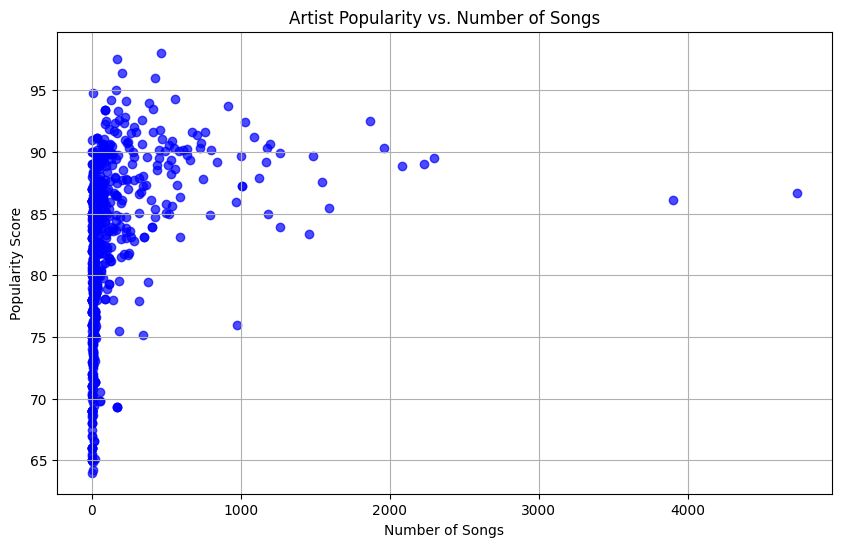

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df["Top List"], df["Popularity"], color="blue", alpha=0.7)

# Labels and title
plt.xlabel("Number of Songs")
plt.ylabel("Popularity Score")
plt.title("Artist Popularity vs. Number of Songs")
plt.grid(True)

# Show plot
plt.show()

In [14]:
'''
The 4th quadrant - 
x 1000 to 5000
y 80 to 100
This is my skyline quadrant every point is dominating others in atleast or both features
'''

'\nThe 4th quadrant - \nx 1000 to 5000\ny 80 to 100\nThis is my skyline quadrant every point is dominating others in atleast or both features\n'

/Users/sagarmaheshwari/Downloads/Datasets/Projects/projects/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21315 (\N{CJK UNIFIED IDEOGRAPH-5343}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sagarmaheshwari/Downloads/Datasets/Projects/projects/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 33865 (\N{CJK UNIFIED IDEOGRAPH-8449}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sagarmaheshwari/Downloads/Datasets/Projects/projects/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38596 (\N{CJK UNIFIED IDEOGRAPH-96C4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/sagarmaheshwari/Downloads/Datasets/Projects/projects/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21916 (\N{CJK UNIFIED IDEOGRAPH-559C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_fig

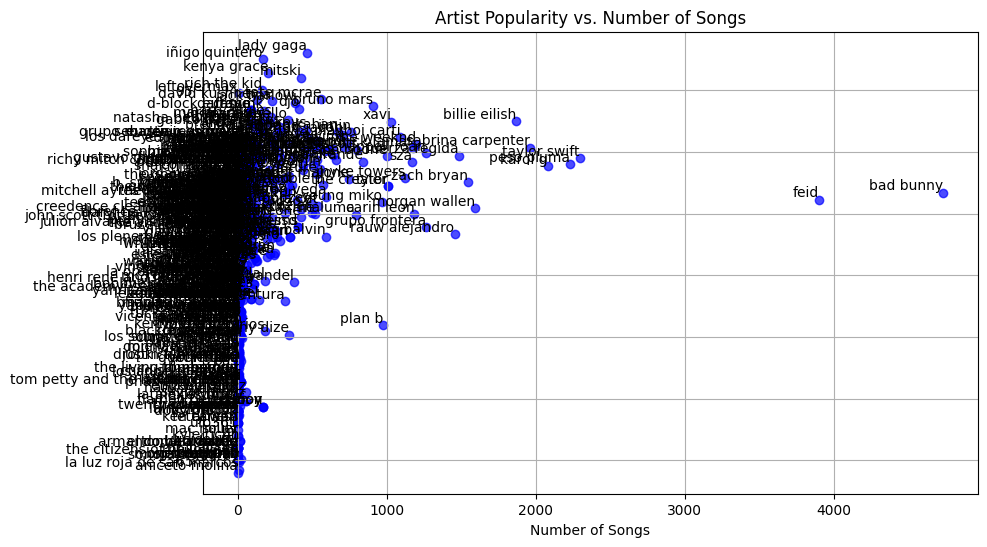

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df["Top List"], df["Popularity"], color="blue", alpha=0.7)

# Add artist names as labels
for i, row in df.iterrows():
    plt.text(row["Top List"], row["Popularity"], row["artists"], fontsize=10, ha="right", va="bottom")

# Labels and title
plt.xlabel("Number of Songs")
plt.ylabel("Popularity Score")
plt.title("Artist Popularity vs. Number of Songs")
plt.grid(True)

# Show plot
plt.show()

In [16]:
'''
Instead of taking skyline quadrant we'll just remove bottom 2 quadrant as we want singers which may have 
less number of songs (not very less that's why removing 1st quadrant) but still have a very high poularity
- New generation artists
- Quality songs over quantity and have cult audience
- Don't get overpowered by bad bunny (outlier)
'''

"\nInstead of taking skyline quadrant we'll just remove bottom 2 quadrant as we want singers which may have \nless number of songs (not very less that's why removing 1st quadrant) but still have a very high poularity\n- New generation artists\n- Quality songs over quantity and have cult audience\n- Don't get overpowered by bad bunny (outlier)\n"

In [17]:
print(df.shape)
df = df[(df['Popularity']>=80) & (df['Top List']>60)]
print("After dropping basis our skyline quadrant ",df.shape)
df.head(2)

(603, 3)
After dropping basis our skyline quadrant  (220, 3)


,artists,Top List,Popularity
1,*nsync,87,87.735632
2,21 savage,470,91.040426


In [18]:
df[['Top List','Popularity']].quantile(np.linspace(0.1,1,10))

,Top List,Popularity
0.1,76.0,83.115274
0.2,90.6,84.646902
0.3,119.7,85.930089
0.4,157.2,86.942599
0.5,212.0,88.017991
0.6,277.2,89.474131
0.7,411.3,90.017466
0.8,552.4,90.689356
0.9,1000.5,92.323647
1.0,4731.0,98.053879


In [19]:
print(f"We have now {df.shape[0]} artists/companies to work on")

We have now 220 artists/companies to work on


In [20]:
print(spotify.shape)
spotify.head()

(66596, 15)


,spotify_id,snapshot_date,name,artists,daily_rank,weekly_movement,popularity,duration_ms,album_name,danceability,energy,loudness,liveness,valence,tempo
0,2plbrEY59IikOBgBGLjaoe,2025-01-31,Die With A Smile,"Lady Gaga, Bruno Mars",1,1,100,251667,Die With A Smile,0.521,0.59200,-7.777,0.1220,0.535,157.969
1,3sK8wGT43QFpWrvNQsrQya,2025-01-31,DtMF,Bad Bunny,2,-1,98,237117,DeBÍ TiRAR MáS FOToS,0.625,0.13100,-27.405,0.0807,0.032,136.020
2,4wJ5Qq0jBN4ajy7ouZIV1c,2025-01-31,APT.,"ROSÉ, Bruno Mars",3,0,91,169917,rosie,0.777,0.78300,-4.477,0.3550,0.939,149.027
3,2lTm559tuIvatlT1u0JYG2,2025-01-31,BAILE INoLVIDABLE,Bad Bunny,4,0,95,367725,DeBÍ TiRAR MáS FOToS,0.168,0.00332,-46.113,0.1120,0.219,119.387
4,5TFD2bmFKGhoCRbX61nXY5,2025-01-31,NUEVAYoL,Bad Bunny,5,1,94,183685,DeBÍ TiRAR MáS FOToS,0.142,0.19500,-20.024,0.2040,0.120,137.922


In [21]:
artists_to_keep = set(df['artists'].to_list())

def keep_artist(x):
    x = x.split(",")
    x = [i.lower().strip() for i in x]
    inter_len = set(x) & artists_to_keep
    if len(inter_len)==len(x):
        return 1
    else:
        return 0
    
spotify['Keep'] = spotify['artists'].apply(keep_artist)
print("Artists combination at present: ", spotify['artists'].nunique())
print("Artists combination after dropping non-relevant artists: ", spotify[spotify['Keep']==1]['artists'].nunique())
print("Songs Distribution") # Very few songs got dropped justifying that we are not dropping any major data points
spotify['Keep'].value_counts()

Artists combination at present:  609
Artists combination after dropping non-relevant artists:  276
Songs Distribution


Keep
1    60177
0     6419
Name: count, dtype: int64

In [22]:
print(spotify.shape)
spotify = spotify[spotify['Keep']==1].drop(columns='Keep', axis=1)
print("After dropping non-relevant artists ",spotify.shape)
spotify.head()

(66596, 16)
After dropping non-relevant artists  (60177, 15)


,spotify_id,snapshot_date,name,artists,daily_rank,weekly_movement,popularity,duration_ms,album_name,danceability,energy,loudness,liveness,valence,tempo
0,2plbrEY59IikOBgBGLjaoe,2025-01-31,Die With A Smile,"Lady Gaga, Bruno Mars",1,1,100,251667,Die With A Smile,0.521,0.59200,-7.777,0.1220,0.535,157.969
1,3sK8wGT43QFpWrvNQsrQya,2025-01-31,DtMF,Bad Bunny,2,-1,98,237117,DeBÍ TiRAR MáS FOToS,0.625,0.13100,-27.405,0.0807,0.032,136.020
2,4wJ5Qq0jBN4ajy7ouZIV1c,2025-01-31,APT.,"ROSÉ, Bruno Mars",3,0,91,169917,rosie,0.777,0.78300,-4.477,0.3550,0.939,149.027
3,2lTm559tuIvatlT1u0JYG2,2025-01-31,BAILE INoLVIDABLE,Bad Bunny,4,0,95,367725,DeBÍ TiRAR MáS FOToS,0.168,0.00332,-46.113,0.1120,0.219,119.387
4,5TFD2bmFKGhoCRbX61nXY5,2025-01-31,NUEVAYoL,Bad Bunny,5,1,94,183685,DeBÍ TiRAR MáS FOToS,0.142,0.19500,-20.024,0.2040,0.120,137.922


### Making Stocks Data

In [23]:
stocks = spotify[['snapshot_date','name','artists','daily_rank','weekly_movement','popularity']].copy()
stocks['artists'] = stocks['artists'].str.split(",")
stocks = stocks.explode(column='artists').reset_index(drop=True)
stocks['artists'] = stocks['artists'].str.lower()
stocks['artists'] = stocks['artists'].str.strip()
stocks.head()

,snapshot_date,name,artists,daily_rank,weekly_movement,popularity
0,2025-01-31,Die With A Smile,lady gaga,1,1,100
1,2025-01-31,Die With A Smile,bruno mars,1,1,100
2,2025-01-31,DtMF,bad bunny,2,-1,98
3,2025-01-31,APT.,rosé,3,0,91
4,2025-01-31,APT.,bruno mars,3,0,91


In [24]:
stocksdf = stocks.groupby(['snapshot_date','artists']).agg({'name':'nunique',   #Previous was count
                                                'daily_rank':'mean',
                                                'weekly_movement':'mean', #->previously was max
                                                'popularity':'max'}).reset_index()
stocksdf['snapshot_date'] = pd.to_datetime(stocksdf['snapshot_date'])
stocksdf

,snapshot_date,artists,name,daily_rank,weekly_movement,popularity
0,2023-10-18,21 savage,1,40.000000,0.000000,90
1,2023-10-18,arctic monkeys,1,17.000000,0.000000,95
2,2023-10-18,bad bunny,23,23.769231,0.000000,91
3,2023-10-18,bad gyal,1,35.000000,0.000000,91
4,2023-10-18,bellakath,1,44.000000,0.000000,83
...,...,...,...,...,...,...
39489,2025-01-31,the neighbourhood,1,40.000000,-4.000000,89
39490,2025-01-31,the weeknd,2,16.000000,1.666667,93
39491,2025-01-31,tito double p,4,27.600000,-2.000000,89
39492,2025-01-31,travis scott,1,10.500000,39.500000,84


In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

# Define the time windows
today = stocksdf['snapshot_date'].max()
time_windows = {
    "Last 1 Month": today - timedelta(days=30),
    "Last 3 Months": today - timedelta(days=90),
    "Last 6 Months": today - timedelta(days=180),
    # "Last 12 Months": today - timedelta(days=365)
    "Lifetime": today - timedelta(days=3650),
}

def exponential_decay_weighted_momentum(df):
    df = df.sort_values(by="snapshot_date", ascending=False)
    df["Decay_Weight"] = np.exp(-0.1 * np.arange(len(df)))
    return (df["weekly_movement"] * df["Decay_Weight"]).sum()

# end_date = stocksdf['snapshot_date'].max()
# start_date = end_date - timedelta(days=90)
def get_top_artists(df, start_date, end_date, period_name):
    df_period = df[(df['snapshot_date'] >= start_date) & (df['snapshot_date'] <= end_date)]
    print(df_period['snapshot_date'].max(), df_period['snapshot_date'].min())
        
    # Group by artist and calculate metrics
    artist_stats = df_period.groupby("artists").agg(
        avg_rank=("daily_rank", "mean"),  # Using average rank for fairness
        rank_variance=("daily_rank", "var"),
        total_popularity=("popularity", "max"),  # Taking the most popular song
        total_songs=("name", "sum")  # Total number of top 50 songs
    ).reset_index()
    
    # Apply exponential decay to weekly movement
    # Artists with only +ve movements will have high exp_momentum
    artist_stats["exp_momentum"] = df_period.groupby("artists").apply(exponential_decay_weighted_momentum).reset_index(drop=True)
    
    # Handle NaNs in variance (single-rank artists)
    artist_stats["rank_variance"] = artist_stats["rank_variance"].fillna(0)
    
    # Compute Z-score normalization
    for col in ["avg_rank", "total_popularity", "exp_momentum", "total_songs"]:
        artist_stats[f"{col}_z"] = (artist_stats[col] - artist_stats[col].mean()) / (artist_stats[col].std() + 1e-6)
    
    # DYNAMIC WEIGHTAGE
    # Select z-score features
    temp = artist_stats[["avg_rank_z", "exp_momentum_z", "total_popularity_z", "total_songs_z"]].copy()
    features = temp[["avg_rank_z", "exp_momentum_z", "total_popularity_z", "total_songs_z"]]
    
    # PCA requires standardized input, but your features are already z-scores
    # Still we standardize again just to be safe (it won't harm)
    X = StandardScaler().fit_transform(features)
    
    # Fit PCA to reduce to 1 component (we only want to extract weights)
    pca = PCA(n_components=1)
    pca.fit(X)
    
    # Extract weights (1D array of loadings for each feature)
    weights = pca.components_[0]
    weights = [abs(x) for x in weights]
    
    score_dict = dict(zip(features.columns, weights))
    
    artist_stats["final_score"] = (
            (1 - artist_stats["avg_rank_z"]) * score_dict["avg_rank_z"] +  # Rank importance
            artist_stats["total_popularity_z"] * score_dict['total_popularity_z'] +  # Popularity importance
            artist_stats["exp_momentum_z"] * score_dict["exp_momentum_z"] +  # Trend importance
            artist_stats["total_songs_z"] * score_dict['total_songs_z']  # More songs = higher score
        )
    print(f"\nTop 10 Artists for {period_name}:\n")
    print(artist_stats.sort_values(by='final_score', ascending=False).head(10))
    return artist_stats

time_period_dfs = {}
# Compute rankings for each time period
for period, start_date in time_windows.items():
    time_period_dfs[period] = get_top_artists(stocksdf, start_date, today, period)

2025-01-31 00:00:00 2025-01-01 00:00:00

Top 10 Artists for Last 1 Month:

           artists   avg_rank  rank_variance  total_popularity  total_songs  \
5        bad bunny  19.052044       4.817755                98          567   
10      bruno mars  19.341308      13.492933               100          113   
44       lady gaga   9.489247       9.181362               100           31   
8    billie eilish  16.674194       5.232645                97           62   
27   gracie abrams  18.997312      30.756705                96           58   
43  kendrick lamar  19.507680       8.422447                91          151   
25      gigi perez  13.096774       7.306989                94           31   
63   playboi carti  14.160714       6.371362                93           28   
17           dei v  12.000000      13.804444                92           26   
83      the weeknd  19.268817      11.232736                93           62   

    exp_momentum  avg_rank_z  total_popularity_z  exp_m

/var/folders/mc/r_50nzwn1nq4hv1x9459pn4r0000gn/T/ipykernel_94157/615072745.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  artist_stats["exp_momentum"] = df_period.groupby("artists").apply(exponential_decay_weighted_momentum).reset_index(drop=True)
/var/folders/mc/r_50nzwn1nq4hv1x9459pn4r0000gn/T/ipykernel_94157/615072745.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  artist_stats["exp_momentum"]

In [26]:
finaldf = time_period_dfs['Lifetime'][['artists','total_popularity','total_songs','final_score']].copy()
for i in ['Last 6 Months','Last 3 Months','Last 1 Month']:
    df = time_period_dfs[i]
    finaldf = finaldf.merge(df[['artists','final_score']], suffixes=(None, f'_{i[5]}'), how='left',on='artists')
finaldf = finaldf.fillna(0)
finaldf[['final_score','final_score_6','final_score_3','final_score_1']] = finaldf[['final_score','final_score_6','final_score_3','final_score_1']].apply(lambda x: round(x,2))
finaldf

,artists,total_popularity,total_songs,final_score,final_score_6,final_score_3,final_score_1
0,*nsync,91,67,0.02,0.64,0.00,0.00
1,21 savage,97,290,1.22,0.00,0.00,0.00
2,adam port,92,76,-0.01,0.59,0.00,0.00
3,alvaro diaz,84,62,-1.26,0.00,0.00,0.00
4,andy williams,93,65,1.30,1.62,1.77,0.00
...,...,...,...,...,...,...,...
214,yng lvcas,93,228,0.08,-1.47,0.00,0.00
215,young miko,95,903,2.06,0.06,-1.30,-1.64
216,yseult,93,75,0.55,0.85,0.00,0.00
217,zach bryan,94,1359,2.20,1.54,-0.21,-0.61


In [27]:
### TECHNIQUE 1
finaldf['Max Score'] = finaldf[['final_score','final_score_6','final_score_3','final_score_1']].max(axis=1)

### TECHNIQUE 2
weights = {
    "final_score_1": np.exp(-0.0),     # most recent → weight = 1
    "final_score_3": np.exp(-0.1),     # less recent
    "final_score_6": np.exp(-0.2),
    "final_score": np.exp(-.3),    # least recent
}
weights

finaldf["Score"] = (
    finaldf["final_score_1"] * weights["final_score_1"] +
    finaldf["final_score_3"] * weights["final_score_3"] +
    finaldf["final_score_6"] * weights["final_score_6"] +
    finaldf["final_score"] * weights["final_score"]
)
finaldf.sort_values(by='Score', ascending=False)

,artists,total_popularity,total_songs,final_score,final_score_6,final_score_3,final_score_1,Max Score,Score
13,bad bunny,98,3373,5.49,4.90,5.47,6.37,6.37,19.398333
26,bruno mars,100,440,2.62,3.65,3.74,3.40,3.74,11.713403
113,lady gaga,100,166,3.04,3.34,3.28,3.38,3.38,11.334515
64,feid,97,3140,5.32,4.14,2.65,1.32,5.32,11.048517
19,billie eilish,100,969,2.68,3.33,2.65,2.78,3.33,9.889585
...,...,...,...,...,...,...,...,...,...
192,tego calderón,85,251,-1.20,-1.83,-1.74,0.00,0.00,-3.961676
56,don omar,86,244,-1.10,-1.51,-1.63,-1.08,-1.08,-4.606068
93,jhayco,93,120,-0.33,-1.99,-1.73,-1.55,-0.33,-4.989113
188,tainy,90,143,-1.04,-1.87,-1.67,-1.44,-1.04,-5.252556


In [28]:
finaldf[['Max Score','Score']].quantile(np.linspace(0.1,1,10))

,Max Score,Score
0.1,0.000,-1.588590
0.2,0.018,-0.711566
0.3,0.360,-0.138148
0.4,0.566,0.299291
0.5,0.780,0.508842
0.6,1.110,1.073236
0.7,1.522,1.930267
0.8,1.878,3.284773
0.9,2.280,5.395574
1.0,6.370,19.398333


In [29]:
from scipy import stats
stats.percentileofscore(finaldf['Max Score'], 1.4, kind='weak'), stats.percentileofscore(finaldf['Score'], 1.9, kind='weak')

(68.03652968036529, 69.40639269406392)

In [30]:
finaldf[finaldf['Max Score']>1.4].shape, finaldf[finaldf['Score']>1.9].shape

((70, 9), (67, 9))

In [31]:
# KEEPiNG SCORE columns as it is more reliable and logical

In [32]:
print("Artists previous ",finaldf.shape)
finaldf = finaldf[finaldf['Score']>0]   #Previous was 1.9
print("Artists dropping low scored artists ",finaldf.shape)
finaldf

Artists previous  (219, 9)
Artists dropping low scored artists  (148, 9)


,artists,total_popularity,total_songs,final_score,final_score_6,final_score_3,final_score_1,Max Score,Score
0,*nsync,91,67,0.02,0.64,0.00,0.00,0.64,0.538804
1,21 savage,97,290,1.22,0.00,0.00,0.00,1.22,0.903798
2,adam port,92,76,-0.01,0.59,0.00,0.00,0.59,0.475643
4,andy williams,93,65,1.30,1.62,1.77,0.00,1.77,3.890970
5,anitta,96,163,1.11,-0.15,0.10,0.00,1.11,0.789982
...,...,...,...,...,...,...,...,...,...
212,yeat,94,178,0.78,0.00,0.00,0.00,0.78,0.577838
213,yg marley,95,53,0.48,0.00,0.00,0.00,0.48,0.355593
216,yseult,93,75,0.55,0.85,0.00,0.00,0.85,1.103371
217,zach bryan,94,1359,2.20,1.54,-0.21,-0.61,2.20,2.090630


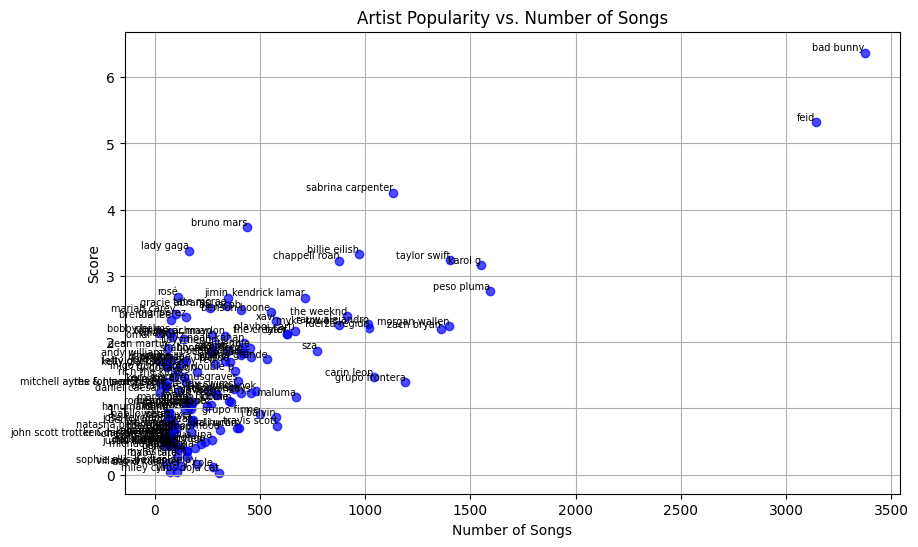

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(finaldf["total_songs"], finaldf["Max Score"], color="blue", alpha=0.7)

for i, row in finaldf.iterrows():
    plt.text(row["total_songs"], row["Max Score"], row["artists"], fontsize=7, ha="right", va="bottom")

# Labels and title
plt.xlabel("Number of Songs")
plt.ylabel("Score")
plt.title("Artist Popularity vs. Number of Songs")
plt.grid(True)

# Show plot
plt.show()

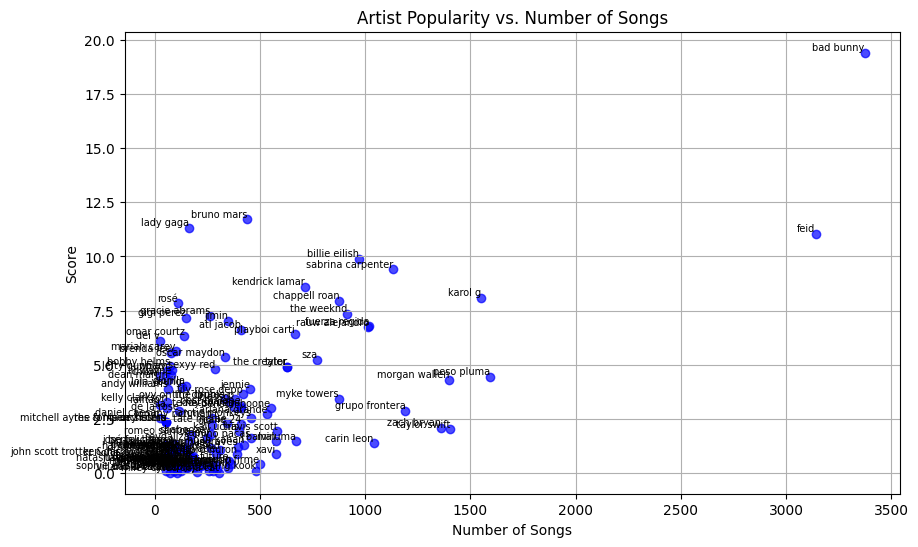

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(finaldf["total_songs"], finaldf["Score"], color="blue", alpha=0.7)

for i, row in finaldf.iterrows():
    plt.text(row["total_songs"], row["Score"], row["artists"], fontsize=7, ha="right", va="bottom")

# Labels and title
plt.xlabel("Number of Songs")
plt.ylabel("Score")
plt.title("Artist Popularity vs. Number of Songs")
plt.grid(True)

# Show plot
plt.show()

### COSTING

In [35]:
costed = finaldf[['artists','total_songs','total_popularity','final_score_3','Score']].copy()
costed

,artists,total_songs,total_popularity,final_score_3,Score
0,*nsync,67,91,0.00,0.538804
1,21 savage,290,97,0.00,0.903798
2,adam port,76,92,0.00,0.475643
4,andy williams,65,93,1.77,3.890970
5,anitta,163,96,0.10,0.789982
...,...,...,...,...,...
212,yeat,178,94,0.00,0.577838
213,yg marley,53,95,0.00,0.355593
216,yseult,75,93,0.00,1.103371
217,zach bryan,1359,94,-0.21,2.090630


In [36]:
# import requests
# from bs4 import BeautifulSoup

# def cost(x):
#     try:
#         url = f"https://seattletalentbuying.com/artists/{x}/"
#         headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36'}
        
#         response = requests.get(url, headers=headers)
#         soup = BeautifulSoup(response.text, 'html.parser')
#         # print(soup)
#         div = soup.find_all('div',class_='et_pb_text_inner')
#         return str(div[5].text)+"-"+str(div[7].text)
#     except:
#         return 0

# costed['artists cost'] = costed['artists'].apply(lambda x: cost(x.replace(" ","-")))
# costed

In [37]:
costed.groupby(['total_popularity','Score']).agg({'artists':'count'}).reset_index().sort_values(by='artists', ascending=False)

,total_popularity,Score,artists
38,92,0.475643,5
112,98,0.113921,2
21,90,0.758561,2
17,90,0.266695,2
33,91,2.366126,2
...,...,...,...
42,92,3.280819,1
41,92,1.017219,1
40,92,0.694363,1
39,92,0.508842,1


In [38]:
# costed = costed.drop_duplicates(subset=['total_popularity','Score'])
# print(costed.shape)
# costed

In [39]:
print(costed['artists'].tolist())

['*nsync', '21 savage', 'adam port', 'andy williams', 'anitta', 'arctic monkeys', 'ariana grande', 'atl jacob', 'baby tate', 'bad bunny', 'bellakath', 'benny blanco', 'benson boone', 'billie eilish', 'bing crosby', 'bizarrap', 'blessd', 'bobby helms', 'brenda lee', 'bruno mars', 'calle 24', 'carin leon', 'chappell roan', 'charli xcx', 'chino pacas', 'chuwi', 'coldplay', 'cris mj', 'dani flow', 'daniel caesar', 'darell', 'david kushner', 'de la rose', 'dean martin', 'dei v', 'djo', 'doja cat', 'dua lipa', 'feid', 'flo milli', 'floyymenor', 'fuerza regida', 'future', 'gigi perez', 'glorilla', 'gracie abrams', 'grupo firme', 'grupo frontera', 'hanumankind', 'harry styles', 'illit', 'iñigo quintero', 'j balvin', 'j. cole', 'jennie', 'jid', 'jimin', 'john scott trotter & his orchestra', 'josé feliciano', 'jung kook', 'justin bieber', 'kacey musgraves', 'kali uchis', 'kalmi', 'kanye west', 'kapo', 'karol g', 'keinemusik', 'kelly clarkson', 'ken darby singers', 'kendrick lamar', 'kenya grace'

### Filter 3

In [40]:
costed[costed['artists'].isin(['arctic monkeys','fuerza regida','grupo frontera'])]

,artists,total_songs,total_popularity,final_score_3,Score
7,arctic monkeys,459,96,0.63,2.564486
69,fuerza regida,1021,95,2.12,6.778424
78,grupo frontera,1191,91,0.90,2.884671


In [41]:
### DROPPING NON RELEVANT BANDS
print(costed.shape)
costed = costed[~costed['artists'].isin(['arctic monkeys','grupo frontera','wham!','carin leon','one direction'])] #for wham reunion unlikelikely
print("DROPPING NON RELEVANT BANDS", costed.shape)
costed

(148, 5)
DROPPING NON RELEVANT BANDS (143, 5)


,artists,total_songs,total_popularity,final_score_3,Score
0,*nsync,67,91,0.00,0.538804
1,21 savage,290,97,0.00,0.903798
2,adam port,76,92,0.00,0.475643
4,andy williams,65,93,1.77,3.890970
5,anitta,163,96,0.10,0.789982
...,...,...,...,...,...
212,yeat,178,94,0.00,0.577838
213,yg marley,53,95,0.00,0.355593
216,yseult,75,93,0.00,1.103371
217,zach bryan,1359,94,-0.21,2.090630


In [42]:
# dict(zip(costed['artists'],costed['artists cost']))

### MAPPING COST AND AUDIENCE

In [43]:
temp = pd.read_excel('Conclusion.xlsx', sheet_name='Artist Cost Df')
temp.head()

,artists,Estimated Fee,Notes,Est. Audience Draw,Data Source
0,Andy Williams,50000–150000,Legacy artist (tribute acts),"1,000-5,000",Legacy Artist Data
1,Arctic Monkeys,750000–1500000,Rock band (festival headliners),"15,000-30,000",2023 Tour Grosses
2,Ariana Grande,1800000–3000000,Pop superstar,"18,000-40,000",Sweetener Tour
3,ATL Jacob,30000–80000,Rising hip-hop producer,"500-2,000",Producer Turned Performer
4,Bad Bunny,1500000–3000000,Latin megastar,"35,000-60,000",2023 Highest-Grossing Tour


In [44]:
# temp = pd.read_clipboard()
# temp.head()

In [45]:
temp['artists'] = temp['artists'].str.lower()
temp['artists'] = temp['artists'].str.strip()
temp['Notes'] = temp['Notes'].str.strip()
temp['Estimated Fee'] = temp['Estimated Fee'].str.strip()
temp['Estimated Fee - Min'] = temp['Estimated Fee'].apply(lambda x: str(x).split("–")[0])
temp['Estimated Fee - Max'] = temp['Estimated Fee'].apply(lambda x: str(x).split("–")[1])
temp['Est. Audience Draw'] = temp['Est. Audience Draw'].str.strip()
temp['Audience - Min'] = temp['Est. Audience Draw'].apply(lambda x: str(x).split("-")[0])
temp['Audience - Min'] = temp['Audience - Min'].apply(lambda x: x.replace(",",""))
temp['Audience - Max'] = temp['Est. Audience Draw'].apply(lambda x: str(x).split("-")[1])
temp['Audience - Max'] = temp['Audience - Max'].apply(lambda x: x.replace(",",""))
temp.head()

,artists,Estimated Fee,Notes,Est. Audience Draw,Data Source,Estimated Fee - Min,Estimated Fee - Max,Audience - Min,Audience - Max
0,andy williams,50000–150000,Legacy artist (tribute acts),"1,000-5,000",Legacy Artist Data,50000,150000,1000,5000
1,arctic monkeys,750000–1500000,Rock band (festival headliners),"15,000-30,000",2023 Tour Grosses,750000,1500000,15000,30000
2,ariana grande,1800000–3000000,Pop superstar,"18,000-40,000",Sweetener Tour,1800000,3000000,18000,40000
3,atl jacob,30000–80000,Rising hip-hop producer,"500-2,000",Producer Turned Performer,30000,80000,500,2000
4,bad bunny,1500000–3000000,Latin megastar,"35,000-60,000",2023 Highest-Grossing Tour,1500000,3000000,35000,60000


In [46]:
finalcosted = costed.merge(temp[['artists','Estimated Fee - Min','Estimated Fee - Max','Audience - Min','Audience - Max']],how='left')
finalcosted = finalcosted.merge(songs_per_artist, on='artists',how='left')
# finalcosted = finalcosted.drop(['artists cost'], axis=1)
finalcosted

,artists,total_songs,total_popularity,final_score_3,Score,Estimated Fee - Min,Estimated Fee - Max,Audience - Min,Audience - Max,name
0,*nsync,67,91,0.00,0.538804,1000000,2000000,15000,30000,1
1,21 savage,290,97,0.00,0.903798,400000,800000,8000,18000,16
2,adam port,76,92,0.00,0.475643,50000,150000,1000,4000,1
3,andy williams,65,93,1.77,3.890970,50000,150000,1000,5000,2
4,andy williams,65,93,1.77,3.890970,50000,150000,1000,5000,2
...,...,...,...,...,...,...,...,...,...,...
141,yeat,178,94,0.00,0.577838,300000,600000,6000,15000,3
142,yg marley,53,95,0.00,0.355593,50000,150000,1000,5000,1
143,yseult,75,93,0.00,1.103371,50000,150000,1000,5000,1
144,zach bryan,1359,94,-0.21,2.090630,200000,300000,10000,15000,18


In [47]:
constraint = finalcosted[['artists','name','total_popularity','Score','Estimated Fee - Min','Audience - Min','Audience - Max']].copy()
constraint.head()

,artists,name,total_popularity,Score,Estimated Fee - Min,Audience - Min,Audience - Max
0,*nsync,1,91,0.538804,1000000,15000,30000
1,21 savage,16,97,0.903798,400000,8000,18000
2,adam port,1,92,0.475643,50000,1000,4000
3,andy williams,2,93,3.890970,50000,1000,5000
4,andy williams,2,93,3.890970,50000,1000,5000


In [48]:
constraint.shape, constraint[constraint['name']>=5].shape

((146, 7), (46, 7))

In [49]:
constraint[constraint['name']>=20]

,artists,name,total_popularity,Score,Estimated Fee - Min,Audience - Min,Audience - Max
10,bad bunny,57,98,19.398333,1500000,35000,60000
39,feid,23,97,11.048517,500000,8000,18000
43,future,26,96,0.543940,500000,10000,20000
64,kanye west,22,97,0.209435,15000000,20000,50000
70,kendrick lamar,22,98,8.598286,525000,10000,22000
88,metro boomin,21,96,0.413722,400000,10000,20000
112,rauw alejandro,25,93,6.745044,700000,15000,30000
125,taylor swift,65,100,2.030157,3755000,50000,90000
136,ty dolla $ign,20,97,0.468722,200000,3000,8000


In [50]:
constraint[constraint['Estimated Fee - Min'].isna()]

,artists,name,total_popularity,Score,Estimated Fee - Min,Audience - Min,Audience - Max


### PROBLEM WITH MAX AUDIENCE

In [65]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD
import pulp
solver = pulp.GLPK_CMD(msg=True)

players_df = constraint[['artists','name','Score','Estimated Fee - Min','Audience - Max']].copy()
players_df = players_df[players_df['name']>4]
players_df.columns = ['artist_name','total_songs','score','fee','audience']
players_df = players_df.reset_index()
players_df['fee'] = players_df['fee'].astype('int64')
players_df['audience'] = players_df['audience'].astype('int64')
players_df['index'] = players_df['index'].apply(lambda x:'Artist '+str(x))

# Define the ILP problem
prob = LpProblem("Team_Selection", LpMaximize)

# Define decision variables
player_vars = LpVariable.dicts("index", players_df["index"], cat="Binary")

# Objective function: Maximize total score
prob += lpSum(players_df.loc[i, "score"] * player_vars[players_df.loc[i, "index"]] for i in players_df.index)
# Objective function: Maximize total profit
# prob += lpSum(players_df.loc[i, "profit"] * player_vars[players_df.loc[i, "index"]] for i in players_df.index)

# Constraint: Total cost must not exceed budget
budget_threshold = 1000000  # or whatever your budget is
prob += lpSum([players_df.loc[i, "fee"] * player_vars[players_df.loc[i, "index"]] for i in players_df.index]) <= budget_threshold, "Budget_Constraint"

# Constraint: Total audience must be at least a certain threshold
audience_threshold = 20000  # Replace with your desired number
prob += lpSum([
    players_df.loc[i, "audience"] * player_vars[players_df.loc[i, "index"]] for i in players_df.index]) >= audience_threshold, "Audience_Constraint"


# Constraints
# 1. Total players = 6
prob += lpSum(player_vars[players_df.loc[i, "index"]] for i in players_df.index) <= 8

# Solve the problem
prob.solve()

# Print the selected team
selected_team = [players_df.loc[i, "index"] for i in players_df.index if player_vars[players_df.loc[i, "index"]].value() == 1]

select = players_df[players_df['index'].isin(selected_team)]
print(select.shape[0], " Artists with total fee ", select['fee'].sum(), "will bring ", select['audience'].sum(), " audience")
select

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /var/folders/mc/r_50nzwn1nq4hv1x9459pn4r0000gn/T/6ec3861a630b4b0ba2dc06c27fd2dc4b-pulp.lp
 -o /var/folders/mc/r_50nzwn1nq4hv1x9459pn4r0000gn/T/6ec3861a630b4b0ba2dc06c27fd2dc4b-pulp.sol
Reading problem data from '/var/folders/mc/r_50nzwn1nq4hv1x9459pn4r0000gn/T/6ec3861a630b4b0ba2dc06c27fd2dc4b-pulp.lp'...
3 rows, 46 columns, 138 non-zeros
46 integer variables, all of which are binary
121 lines were read
GLPK Integer Optimizer 5.0
3 rows, 46 columns, 138 non-zeros
46 integer variables, all of which are binary
Preprocessing...
16 constraint coefficient(s) were reduced
3 rows, 38 columns, 114 non-zeros
38 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+06  ratio =  1.000e+06
GM: min|aij| =  3.761e-01  max|aij| =  2.659e+00  ratio =  7.071e+00
EQ: min|aij| =  1.414e-01  max|aij| =  1.000e+00  ratio =  7.071e+00
2N: min|aij| =  1.250e-01  max|aij| =  1.431e+

,index,artist_name,total_songs,score,fee,audience
6,Artist 17,blessd,7,3.290703,40000,6000
8,Artist 23,chappell roan,6,7.967264,75000,6000
11,Artist 39,feid,23,11.048517,500000,18000
26,Artist 104,ovy on the drums,8,3.404245,50000,5000
32,Artist 116,sabrina carpenter,15,9.403356,300000,12000
39,Artist 131,tito double p,6,3.426841,30000,4000


### SELECTING SONGS

In [66]:
select.columns = ['index','artists','songs','Hype Score','Fee','Audience Grab Power']
select['artists'].tolist()

['blessd',
 'chappell roan',
 'feid',
 'ovy on the drums',
 'sabrina carpenter',
 'tito double p']

In [53]:
all_songs['artists'] = all_songs['artists'].str.split(",")
all_songs = all_songs.explode(column='artists').reset_index(drop=True)
all_songs['artists'] = all_songs['artists'].str.lower()
all_songs['artists'] = all_songs['artists'].str.strip()

In [54]:
# Normalize the features
from sklearn.preprocessing import MinMaxScaler

features = ["popularity", "danceability", "energy", "valence", "tempo"]
scaler = MinMaxScaler()
all_songs[features] = scaler.fit_transform(all_songs[features])

# Compute a performance score (weights can be tuned)
all_songs["performance_score"] = (
    0.2 * all_songs["popularity"] +
    0.2 * all_songs["liveness"] +
    0.2 * all_songs["energy"] +
    0.2 * all_songs["danceability"] +
    0.1 * all_songs["valence"] +
    0.1 * all_songs["tempo"]
)

all_songs = all_songs.sort_values(by=['performance_score'], ascending=False)
all_songs = all_songs.drop_duplicates(subset='name')

In [58]:
all_songs.head(2)

,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,duration_ms,album_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,performance_score
18896,3OJDtCdYs8QJnui708tEU3,Soltera,shakira,50,-7,-19,SV,2024-11-01,0.87,False,214642,Soltera,2024-09-25,0.855687,0.766150,2,-4.735,1,0.105,0.167,0.000460,0.949,0.675400,0.316439,4,0.787351
79094,2FoahzOSxJnalPA8aBUme3,all of me,21 savage,49,1,-33,US,2024-01-24,0.86,True,198292,american dream,2024-01-12,0.640362,0.820272,5,-5.708,0,0.304,0.120,0.000012,0.842,0.797377,0.671504,4,0.779415


In [62]:
newdf = song_names_per_artist[song_names_per_artist['artists'].isin(['blessd',
 'chappell roan',
 'feid',
 'ovy on the drums',
 'sabrina carpenter',
 'tito double p', 'gracie abrams'])]
newdf = newdf.merge(all_songs,on='name',how='right')

In [64]:
newdf[newdf['artists_x']=='gracie abrams']

,artists_x,name,spotify_id,artists_y,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,duration_ms,album_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,performance_score
544,gracie abrams,That’s So True,7ne4VBA60CxGM75vw0EYad,gracie abrams,3,1,0,Global Top 50,2025-01-07,0.96,True,166300,The Secret of Us (Deluxe),2024-10-18,0.526973,0.823336,1,-4.169,1,0.0368,0.2140,0.000000,0.1590,0.374994,0.366682,4,0.568029
837,gracie abrams,Close To You,5MPi9e7z46wopyad10R6qx,gracie abrams,47,1,-11,US,2024-06-21,0.80,False,225973,Close To You,2024-06-07,0.564769,0.748790,6,-7.947,1,0.0746,0.0312,0.000064,0.0826,0.307453,0.446080,4,0.514585
988,gracie abrams,"I Love You, I'm Sorry",51rfRCiUSvxXlCSCfIztBy,gracie abrams,16,6,0,Global Top 50,2024-11-20,0.90,True,157146,The Secret of Us,2024-06-21,0.499485,0.412822,10,-7.507,1,0.0330,0.6560,0.000000,0.1330,0.340719,0.410521,3,0.464185
990,gracie abrams,us. (feat. Taylor Swift),0hhzNPE68LWLfgZwdpxVdR,gracie abrams,43,-5,7,US,2024-06-28,0.79,True,242666,The Secret of Us,2024-06-21,0.502921,0.562935,7,-6.486,1,0.0296,0.4980,0.000000,0.0911,0.394147,0.328105,4,0.461616


In [68]:
newdf.groupby('artists_x').agg({'performance_score':'mean','name':'nunique','duration_ms':'sum'}).reset_index()

,artists_x,performance_score,name,duration_ms
0,blessd,0.608032,7,1364925
1,chappell roan,0.569591,6,1306524
2,feid,0.603643,23,4220872
3,gracie abrams,0.502104,4,792085
4,ovy on the drums,0.602663,8,1570495
5,sabrina carpenter,0.572132,15,2678183
6,tito double p,0.601519,6,959760


In [71]:
answer = pd.DataFrame()
for key in ['blessd',
 'chappell roan',
 'feid',
 'ovy on the drums',
 'sabrina carpenter',
 'tito double p', 'gracie abrams']:
    answer = pd.concat([answer,newdf[newdf['artists_x']==key].head(12)])
print("Concert Duration ",answer['duration_ms'].sum()," ms ",answer['duration_ms'].sum()/(1000*60*60), " hrs")
answer

Concert Duration  10293201  ms  2.8592225  hrs


,artists_x,name,spotify_id,artists_y,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,is_explicit,duration_ms,album_name,album_release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,performance_score
179,blessd,Soltera - W Sound 01,13BDiikG6y5o5cQTK0HpW6,ovy on the drums,21,3,21,SV,2024-11-05,0.82,True,142022,Soltera (W Sound 01),2024-08-06,0.733135,0.588465,1,-4.147,1,0.2950,0.1550,0.000242,0.1130,0.887096,0.909020,4,0.630532
257,blessd,DEPORTIVO,0fKK51bU6lcCCwdNnv64t3,anuel aa,30,1,4,SV,2025-01-28,0.86,True,218701,DEPORTIVO,2024-11-14,0.827053,0.776362,0,-2.864,1,0.0565,0.5340,0.000404,0.0845,0.788304,0.256832,4,0.614097
269,blessd,Mirame,2btNsI4OvcVl7SAHQQDHFB,ovy on the drums,4,1,0,SV,2024-08-07,0.88,True,157453,Mirame,2024-04-17,0.713664,0.668117,7,-4.449,1,0.0797,0.1410,0.000030,0.0661,0.700602,0.766445,4,0.612281
293,blessd,Mírame,2btNsI4OvcVl7SAHQQDHFB,ovy on the drums,5,0,1,SV,2024-10-29,0.86,True,157453,Mírame,2024-04-17,0.713664,0.668117,7,-4.449,1,0.0797,0.1410,0.000030,0.0661,0.700602,0.766445,4,0.608281
306,blessd,+57,3mg9jYNC1NihbthlglzrWP,feid,26,24,24,SV,2024-12-06,0.86,True,298130,+57,2024-11-08,0.863704,0.725303,1,-3.574,0,0.0981,0.2210,0.000000,0.1060,0.697578,0.268426,4,0.607602
327,blessd,MIRAME REMIX,2S8bH7ABqJ02bWeH8bgQfU,blessd,49,0,1,SV,2025-01-01,0.79,True,238666,MIRAME REMIX,2024-12-11,0.652961,0.677307,7,-4.503,1,0.0839,0.2120,0.000007,0.1230,0.776207,0.766588,4,0.602933
462,blessd,SI SABE FERXXO,7chTH3GBjjAyagf0SPCZDL,blessd,48,2,-11,SV,2024-04-23,0.85,True,152500,SI SABE,2024-01-25,0.723972,0.846823,8,-2.035,0,0.1200,0.0139,0.000004,0.0891,0.492938,0.292249,4,0.580498
27,chappell roan,HOT TO GO!,4xdBrk0nFZaP54vvZj0yx7,chappell roan,11,1,0,US,2024-09-16,0.92,False,184841,The Rise and Fall of a Midwest Princess,2023-09-22,0.742298,0.771256,6,-4.981,1,0.0421,0.0187,0.000000,0.3050,0.964717,0.553102,4,0.699493
292,chappell roan,Red Wine Supernova,7FOgcfdz9Nx5V9lCNXdBYv,chappell roan,29,0,-12,US,2024-08-29,0.89,True,192720,The Rise and Fall of a Midwest Princess,2023-09-22,0.644943,0.835590,9,-4.448,1,0.0441,0.0176,0.000000,0.0847,0.714715,0.458564,4,0.608375
416,chappell roan,"Good Luck, Babe!",0WbMK4wrZ1wFSty9F7FCgu,chappell roan,3,0,0,US,2024-09-25,0.97,False,218423,"Good Luck, Babe!",2024-04-05,0.694193,0.592549,11,-5.960,0,0.0356,0.0502,0.000000,0.0881,0.791329,0.415099,4,0.589611


In [76]:
answer.groupby('artists_x').agg({'performance_score':'mean','name':'unique','duration_ms':'sum'}).reset_index().to_csv("Final Songs.csv",index=False)